# 300 Autoencoder Tutorial Notebook

This Notebook should give a quick introduction to how Autoencoders work. It will be trained on the MNIST handwritten digit dataset. The code is dependant on keras, matplotlib and numpy while using Tensorflow 2.X.


## Sources:
MNIST Database:
 - http://yann.lecun.com/exdb/mnist/

Papers:
 - https://arxiv.org/abs/1805.00251
 - https://arxiv.org/abs/1805.09730

Tutorials:
 - https://blog.keras.io/building-autoencoders-in-keras.html
 
 
 ## Training the Autoencoder
 
 The Autoencoder is composed of an encoder and a decoder half. Once an MNIST image is fed into the network, it is compressed to the *feature_map* layer, which maps the small input space to the generated MNIST images. The image fed into the autoencoder and outputted by it should be identical. The loss function penalizes the network when there is a big difference.
 
 <img src="Autoencoder MNIST Explanation.png">

(60000, 28, 28, 1)
(60000,)


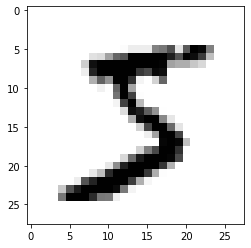

In [19]:
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt



mnist = tf.keras.datasets.mnist

# Expand Dimensions to 3D to add one for the color channel of black and white: expand_dims(train_images, axis=-1)
# Normalize the image by dividing by 255 --> faster convergence
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = np.expand_dims(train_images, axis=-1) / 255.0, np.expand_dims(train_images, axis=-1) / 255.0


# Examples
# Shape is (60000, 28, 28, 1) for 60 000 images with dimensions 28 x 28 and 1 color channel (black and white)
print(train_images.shape)
print(train_labels.shape)

plt.imshow(train_images[0, :, :, 0], cmap='gray_r')

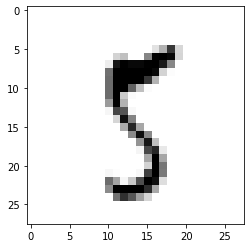

In [20]:
# Helper function to create a batch
# It returns identical image pairs: *train_images* = *y_train_images*

# Sample minibatch from MNIST
def get_MNIST_samples(n_samples):
    # Pick new image samples from dataset
    # Pick random images to help with gradient descent
    image_samples = np.zeros((n_samples, 28, 28, 1))

    for i in range(0, n_samples):
        index = random.randint(0, 59999)
        image_samples[i] = train_images[index]

    # Both x and y are the same, since the autoencoder should produce the same image
    return image_samples, image_samples


# Examples
train_images_example, y_train_images_example = get_MNIST_samples(32)
plt.imshow(train_images_example[0, :, :, 0], cmap='gray_r')

In [21]:
# Define the Encoder, Decoder and the whole Autoencoder with Keras

# Build the encoder
def build_encoder():
    model = Sequential()

    model.add(Flatten(input_shape=(28, 28, 1)))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    return model


# Build the decoder
def build_decoder():
    model = Sequential()

    model.add(Dense(2))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))

    # activation='sigmoid' to get the values for the image between 0 and 1
    model.add(Dense(784, activation='sigmoid'))

    # None ist the batch size, 28 x 28 is the input image with 1 color channel
    model.add(Reshape((28, 28, 1)))

    return model


# Build the Autoencoder by combining the encoder and the decoder
def build_autoencoder(encoder, decoder):
    model = Sequential()

    model.add(encoder)
    model.add(decoder)

    # Loss function and optimizer
    model.compile(loss='binary_crossentropy', optimizer='adam')

    return model

In [24]:
# Train the model

def train(encoder, decoder, autoencoder_model, n_epochs=100, n_batch=32):
    batches_per_epoch = int(60000 / n_batch)

    for epoch in range(0, n_epochs):
        for batch in range(0, batches_per_epoch):

            # Get MNIST images
            train_images, y_train_images = get_MNIST_samples(n_batch)

            # Run a batch through the autoencoder_model
            autoencoder_loss = autoencoder_model.train_on_batch(train_images, y_train_images)

            print('Epoch: ', epoch, '   Batch Number: ', batch, ' / ', batches_per_epoch, '   Autoencoder loss: ',  autoencoder_loss)

            # Save values and models
            if batch % 1800 == 0:
                # Save the generator and discriminator
                encoder.save('encoder.h5', )
                decoder.save('decoder.h5')
                autoencoder_model.save('autoencoder_model.h5')

                # Predict some images to read out the progress of the autoencoder
                autoencoder_model_output = autoencoder_model.predict(train_images)

                # Print generated_images with matplotlib
                # First the images from train_images, then autoencoder_moder_output
                for i in range(1, 5):
                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 3 * (i - 1))
                    if i == 1:
                        plt.title("MNIST")
                    # Plot raw pixel data
                    plt.imshow(train_images[i, :, :, 0], cmap='gray_r')

                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 1 + 3 * (i - 1))
                    if i == 1:
                        plt.title("Generated")
                    # Plot raw pixel data
                    plt.imshow(autoencoder_model_output[i, :, :, 0], cmap='gray_r')

                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 2 + 3 * (i - 1))
                    if i == 1:
                        plt.title("MNIST")
                    # Plot raw pixel data
                    plt.imshow(train_images[i + 4, :, :, 0], cmap='gray_r')

                    # Define subplot of size 5 x 5
                    plt.subplot(4, 4, i + 3 + 3 * (i - 1))
                    if i == 1:
                        plt.title("Generated")
                    # Plot raw pixel data
                    plt.imshow(autoencoder_model_output[i + 4, :, :, 0], cmap='gray_r')

                plt.savefig('plot  epoch ' + '%02d' % epoch + '  batch ' + '%05d' % batch + '.png', dpi=600)
                plt.close()

In [25]:
# Start training cycle

# Build the autoencoder
encoder = build_encoder()
decoder = build_decoder()
autoencoder_model = build_autoencoder(encoder, decoder)

# Train Autoencoder
train(encoder, decoder, autoencoder_model)

Epoch:  0    Batch Number:  0  /  1875    Autoencoder loss:  0.693195641040802
Epoch:  0    Batch Number:  1  /  1875    Autoencoder loss:  0.6925737857818604
Epoch:  0    Batch Number:  2  /  1875    Autoencoder loss:  0.6917673349380493
Epoch:  0    Batch Number:  3  /  1875    Autoencoder loss:  0.689876139163971
Epoch:  0    Batch Number:  4  /  1875    Autoencoder loss:  0.6848605275154114
Epoch:  0    Batch Number:  5  /  1875    Autoencoder loss:  0.6749283671379089
Epoch:  0    Batch Number:  6  /  1875    Autoencoder loss:  0.6561025381088257
Epoch:  0    Batch Number:  7  /  1875    Autoencoder loss:  0.6273826360702515
Epoch:  0    Batch Number:  8  /  1875    Autoencoder loss:  0.5830464959144592
Epoch:  0    Batch Number:  9  /  1875    Autoencoder loss:  0.5309769511222839
Epoch:  0    Batch Number:  10  /  1875    Autoencoder loss:  0.46627214550971985
Epoch:  0    Batch Number:  11  /  1875    Autoencoder loss:  0.3979540765285492
Epoch:  0    Batch Number:  12  /  1875

Epoch:  0    Batch Number:  113  /  1875    Autoencoder loss:  0.2625458538532257
Epoch:  0    Batch Number:  114  /  1875    Autoencoder loss:  0.245770663022995
Epoch:  0    Batch Number:  115  /  1875    Autoencoder loss:  0.23679618537425995
Epoch:  0    Batch Number:  116  /  1875    Autoencoder loss:  0.2610098719596863
Epoch:  0    Batch Number:  117  /  1875    Autoencoder loss:  0.24401800334453583
Epoch:  0    Batch Number:  118  /  1875    Autoencoder loss:  0.26199597120285034
Epoch:  0    Batch Number:  119  /  1875    Autoencoder loss:  0.2458365261554718
Epoch:  0    Batch Number:  120  /  1875    Autoencoder loss:  0.26699668169021606
Epoch:  0    Batch Number:  121  /  1875    Autoencoder loss:  0.23909778892993927
Epoch:  0    Batch Number:  122  /  1875    Autoencoder loss:  0.2561016380786896
Epoch:  0    Batch Number:  123  /  1875    Autoencoder loss:  0.2382844090461731
Epoch:  0    Batch Number:  124  /  1875    Autoencoder loss:  0.2716597020626068
Epoch:  0   

Epoch:  0    Batch Number:  216  /  1875    Autoencoder loss:  0.23982098698616028
Epoch:  0    Batch Number:  217  /  1875    Autoencoder loss:  0.23133142292499542
Epoch:  0    Batch Number:  218  /  1875    Autoencoder loss:  0.24833150207996368
Epoch:  0    Batch Number:  219  /  1875    Autoencoder loss:  0.24040257930755615
Epoch:  0    Batch Number:  220  /  1875    Autoencoder loss:  0.23645029962062836
Epoch:  0    Batch Number:  221  /  1875    Autoencoder loss:  0.2422371357679367
Epoch:  0    Batch Number:  222  /  1875    Autoencoder loss:  0.2108052521944046
Epoch:  0    Batch Number:  223  /  1875    Autoencoder loss:  0.226809561252594
Epoch:  0    Batch Number:  224  /  1875    Autoencoder loss:  0.23237434029579163
Epoch:  0    Batch Number:  225  /  1875    Autoencoder loss:  0.24104531109333038
Epoch:  0    Batch Number:  226  /  1875    Autoencoder loss:  0.23854924738407135


KeyboardInterrupt: 